In [ ]:
! pip install pypdf langchain sentence-transformers chromadb openai umap-learn -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [20]:
import umap
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
import os
from google.colab import userdata
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["HUGGINGFACE_API_KEY"] = userdata.get('HF_TOKEN')

openai_client = OpenAI()

In [5]:
from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction


def load_chroma(pdf_file, collection_name, embedding_function):

    reader = PdfReader(pdf_file)
    pdf_texts = [p.extract_text().strip() for p in reader.pages]

    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )

    character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))


    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    chroma_client = chromadb.Client() # Default chroma client
    chroma_collection = chroma_client.create_collection(collection_name,
                                                        embedding_function=embedding_function)

    ids = [str(i) for i in range(len(token_split_texts))] # ids for each txt chunk
    chroma_collection.add(ids=ids, documents=token_split_texts)

    return chroma_collection

In [6]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

### CREATE CHROMA DB:

In [7]:
data_path = 'drive/My Drive/DATA/advanced_RAG/'

In [8]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(data_path + 'microsoft_annual_report_2022.pdf',
                                collection_name='microsoft_annual_report_2022',
                                embedding_function=embedding_function)
chroma_collection.count()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

349

### UMAP EMBEDDINGS:

In [9]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [06:30<00:00,  1.12s/it]


## Expansion with generated answers

https://arxiv.org/abs/2305.03653

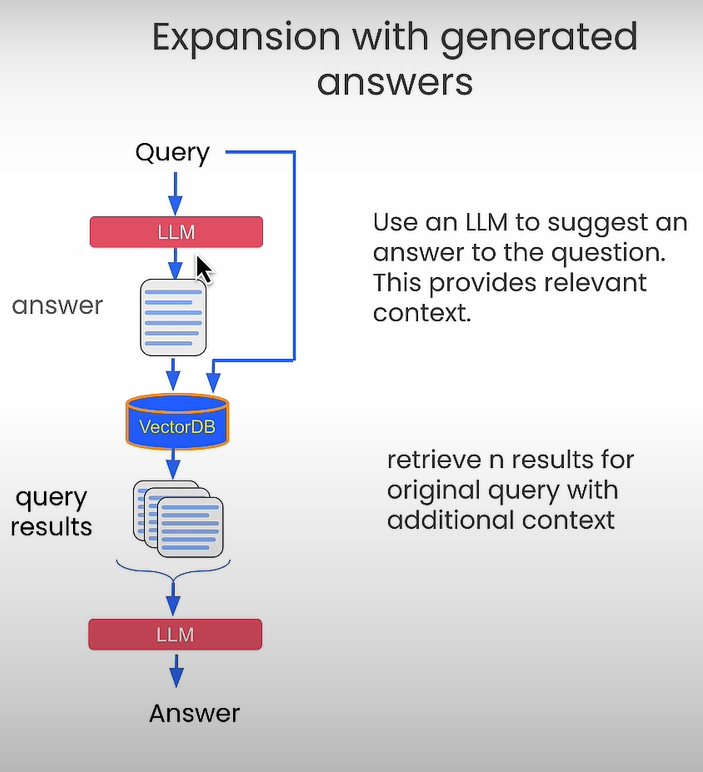

In [10]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. \
            Provide an example answer to the given question, \
            that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [11]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

print(hypothetical_answer)

During the fiscal year, there was minimal turnover within the executive team. One key change that occurred was the appointment of a new Chief Financial Officer in the second quarter. This change was a result of the previous CFO retiring after 10 years of service with the company. Additionally, there were no other significant departures or additions to the executive team during the year. The company remains committed to maintaining a stable and experienced leadership team to drive the company's strategic initiatives forward.


In [12]:
joint_query = f"{original_query} {hypothetical_answer}"
print(joint_query)

Was there significant turnover in the executive team? During the fiscal year, there was minimal turnover within the executive team. One key change that occurred was the appointment of a new Chief Financial Officer in the second quarter. This change was a result of the previous CFO retiring after 10 years of service with the company. Additionally, there were no other significant departures or additions to the executive team during the year. The company remains committed to maintaining a stable and experienced leadership team to drive the company's strategic initiatives forward.


In [13]:
results = chroma_collection.query(query_texts=original_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

the company engaged deloitte & touche llp, an independent registered public accounting firm, to audit and render an opinion on the consolidated financial statements and internal control over financial reporting in accordance with the standards of the public company accounting oversight board ( united states ). the board of directors, through its audit committee, consisting solely of independent directors of the company, meets periodically with management, internal auditors, and our independent registered public accounting firm to ensure that each is meeting its responsibilities and to discuss matters concerning internal controls and financial reporting. deloitte & touche llp and the internal auditors each have full and free access to the audit committee. satya nadella chief executive officer amy e. hood executive vice president and chief financial officer alice l. jolla corporate vice president and chief accounting officer

• we tested the reasonableness of management ’ s judgments reg

In [14]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

88 report of independent registered public accounting firm to the stockholders and the board of directors of microsoft corporation opinion on internal control over financial reporting we have audited the internal control over financial reporting of microsoft corporation and subsidiaries ( the “ company ” ) as of june 30, 2022, based on criteria established in internal control — integrated framework ( 2013 ) issued by the committee of sponsoring organizations of the treadway commission ( coso ). in our opinion, the company maintained, in all material respects, effective internal control over financial reporting as of june 30, 2022, based on criteria establis hed in internal control — integrated framework ( 2013 ) issued by coso. we have also audited, in accordance with the standards of the public company accounting oversight board ( united states ) ( pcaob ), the consolidated financial statements as of and for the year ended june 30, 2022, of the company and

84 report of independent re

In [15]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


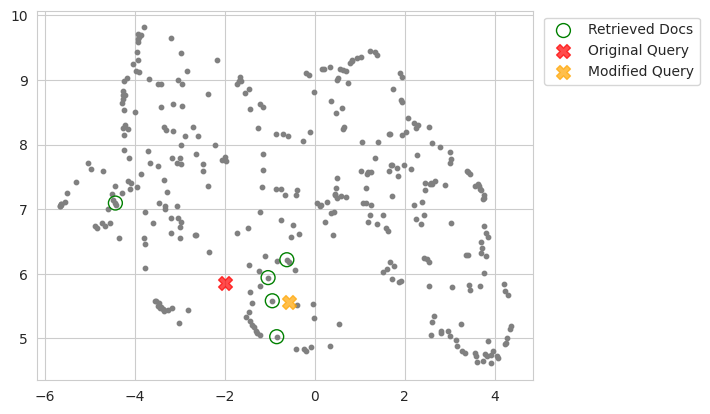

In [31]:
# Plot the projected query and retrieved documents in the embedding space

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0],
            projected_dataset_embeddings[:, 1],
            s=10, color='gray')

plt.scatter(projected_retrieved_embeddings[:, 0],
            projected_retrieved_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label = 'Retrieved Docs')

plt.scatter(projected_original_query_embedding[:, 0],
            projected_original_query_embedding[:, 1],
            s=100, marker='X', color='r', alpha = 0.7, label = 'Original Query')

plt.scatter(projected_augmented_query_embedding[:, 0],
            projected_augmented_query_embedding[:, 1],
            s=100, marker='X', color='orange', alpha = 0.7, label = 'Modified Query')

plt.legend(loc='upper left')

#plt.gca().set_aspect('equal', 'datalim')
plt.legend(bbox_to_anchor=(1.35, 1))
plt.show()

## Expansion with multiple queries


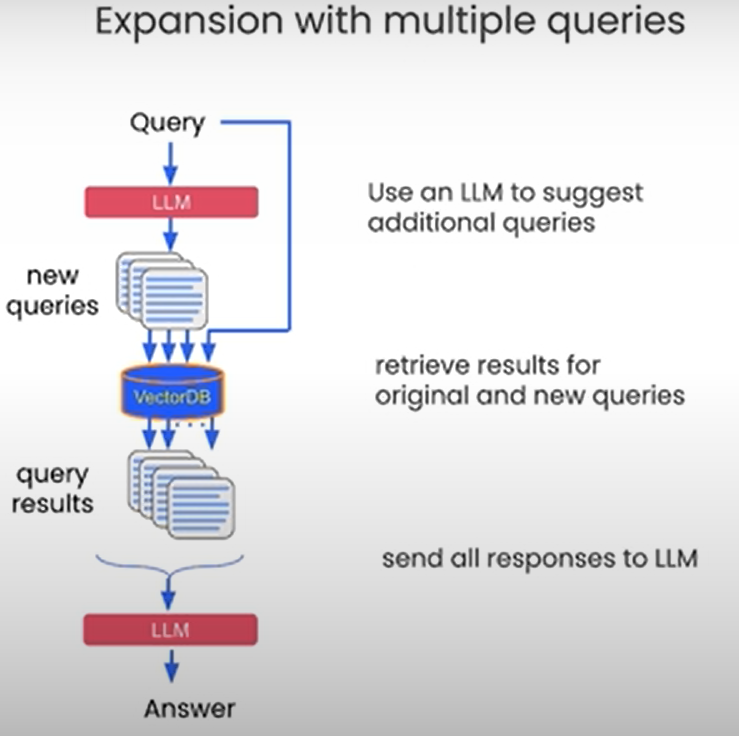

In [32]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. \
            Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find \
            the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. \
            Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [33]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

augmented_queries

['What were the main sources of revenue for the company?',
 'What strategies were implemented to boost revenue growth?',
 'Were there any significant acquisitions or partnerships that impacted revenue?',
 'How did changes in market conditions affect revenue generation?',
 'What percentage of the revenue growth can be attributed to organic growth versus external factors?']

In [34]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses increased $ 1. 7 billion or 8 % driven by investments in commercial sales and linkedin. sales and marketing included a favorable foreign currency impact of 2 %. • general and administrative expenses increased $ 793 million or 16 % driven by investments in corporate functions. operating income increased $ 13. 5 billion or 19 % driven by growth across each of our segments. current year net income and diluted eps were positively impacted by the net tax benefit related to the transfer of intangible properties, which resulted in an increase to net income and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year net income and diluted eps were positively impacted by the net tax benefit related to the india supreme court decision on withholding taxes, which resulted in an increase to net income and diluted eps of $ 620 

In [35]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


In [36]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


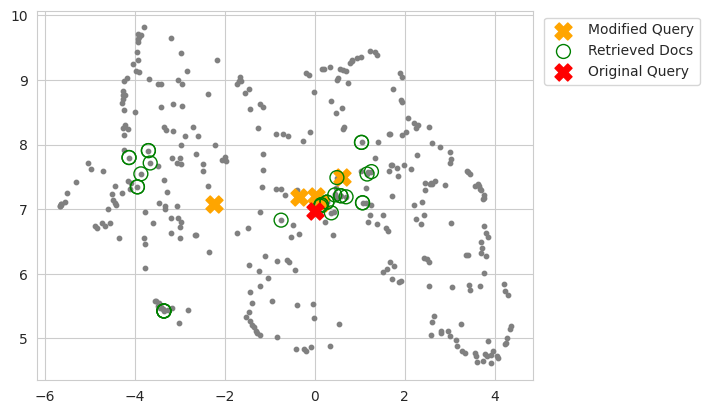

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0],
            projected_dataset_embeddings[:, 1],
            s=10, color='gray')

plt.scatter(project_augmented_queries[:, 0],
            project_augmented_queries[:, 1],
            s=150, marker='X', color='orange', label = 'Modified Query')

plt.scatter(projected_result_embeddings[:, 0],
            projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label = 'Retrieved Docs')

plt.scatter(project_original_query[:, 0],
            project_original_query[:, 1],
            s=150, marker='X', color='r', label = 'Original Query')

plt.legend(loc='upper left')

#plt.gca().set_aspect('equal', 'datalim')
plt.legend(bbox_to_anchor=(1.35, 1))
plt.show()